# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See [this notebook](https://github.com/kundajelab/tfmodisco/blob/de01768331fd63df6cb9d6b9707589928194a1e4/examples/H1ESC_Nanog_gkmsvm/Nanog_GkmExplain_Generate_Data.ipynb) for how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2020-04-27 01:43:35--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.04s   

2020-04-27 01:43:36 (1.97 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2020-04-27 01:43:36--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3191036 (3.0M) [application/octet-stream]
Saving to: 'gkmexplain_positives_hypimpscores.txt.gz'

100%[=

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


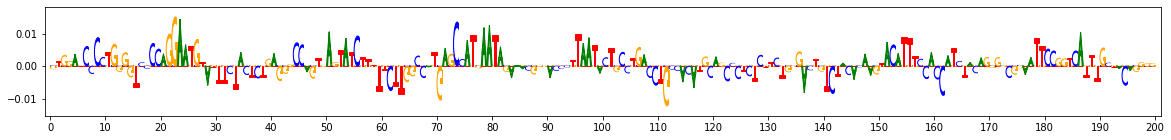

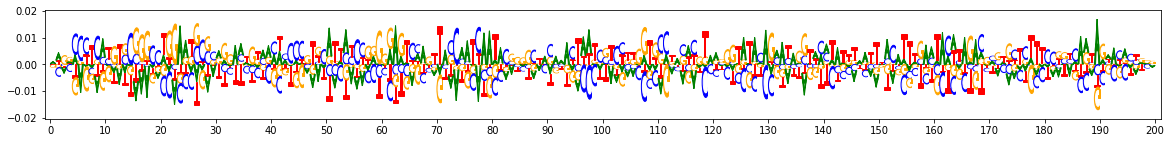

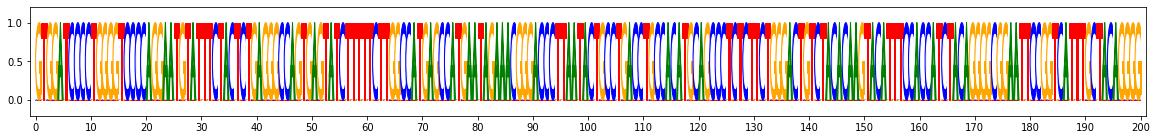

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has the following modifications from the default settings:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- (new in version 0.5.6.0) MEME is run on the seqlets to find 10 motifs, and the significant motifs are used to initialize TF-MoDISco's Leiden clustering. This initialization is handled by the initclusterer_factory argument.
- The code below uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine when run on some computing servers, but not when run on my 6-year-old personal laptop.
- The `final_min_cluster_size` is set to 20 rather than the default of 30. The `final_min_cluster_size` determines the minimum support needed (in terms of number of seqlets) for a cluster to be displayed. It was lowered here to potentially enable better comparison to the MEME results, as the MEME motifs can sometimes have very few seqlets.

MEMORY 0.326217728
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -0.21752344639999993  and  0.13906743924999995
Final raw thresholds are -0.21752344639999993  and  0.13906743924999995
Final transformed thresholds are -0.9723900462962963  and  0.8939699074074074


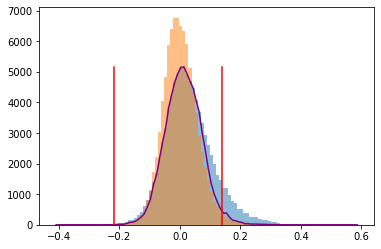

Got 1106 coords
After resolving overlaps, got 1106 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8938699074074075
MEMORY 0.344674304
1106 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [1086]
Idx to activities:  {0: '1'}
MEMORY 0.344686592
On metacluster 0
Metacluster size 1086
Relevant tasks:  ('task0',)
Relevant signs:  (1,)

TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod zoops -nmotifs 10 -p 4 -minw 6 -maxw 50 -objfun classic -revcomp -markov_order 0 -oc meme_out/metacluster0
Duration of MEME: 764.5921130180359 seconds
Skipping motif NDGGVVTGCACATTCCWGGCMTTCY as e-value 1.1 does not meet threshold of 0.05
Skipping motif GAAACATTTACADTCTATTCTCTCTGAVG as e-value 59.0 does not meet threshold of 0.05
Skipping motif TTCAAAGGGMT as e-value 990.0 does not meet threshold of 0.05
Skipping motif KGCCAGSCAGG as e-value 67000.0 does not me

Using TensorFlow backend.


Finished embedding computation in 6.44 s
Starting affinity matrix computations
Normalization computed in 0.1 s
Cosine similarity mat computed in 0.17 s
Normalization computed in 0.09 s
Cosine similarity mat computed in 0.15 s
Finished affinity matrix computations in 0.34 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.649818112
Computed nearest neighbors in 0.74 s
MEMORY 0.66207744
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.66207744
Launching nearest neighbors affmat calculation job
MEMORY 0.682811392
Parallel runs completed
MEMORY 0.562847744
Job completed in: 24.29 s
MEMORY 0.56285184
Launching nearest neighbors affmat calculation job
MEMORY 0.561242112
Parallel runs completed
MEMORY 0.563544064
Job completed in: 24.19 s
MEMORY 0.572985344
(Round 1) Computed affinity matrix on nearest neighbors in 48.79 s
MEMORY 0.575696896
Filtered down to 947 of 1086
(Round 1) Retained 947 rows out of 1086 after filtering
MEMORY 0.575873024
(Round 1) Computi

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6436531149645419
Quality: 0.6453954396401451


  2%|▏         | 1/50 [00:00<00:19,  2.50it/s]

Quality: 0.6454406245711171


 20%|██        | 10/50 [00:04<00:16,  2.36it/s]

Quality: 0.6455149374366334


 78%|███████▊  | 39/50 [00:16<00:04,  2.54it/s]

Quality: 0.6455340044878346


100%|██████████| 50/50 [00:20<00:00,  2.43it/s]

Got 10 clusters after round 1
Counts:
{2: 145, 4: 84, 3: 104, 0: 265, 1: 260, 9: 4, 5: 40, 6: 19, 7: 16, 8: 10}
MEMORY 0.54530048
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.54530048
Aggregating for cluster 0 with 265 seqlets
MEMORY 0.54530048


Trimmed 22 out of 265
Skipped 29 seqlets
Aggregating for cluster 1 with 260 seqlets
MEMORY 0.54530048
Trimmed 5 out of 260
Skipped 40 seqlets
Aggregating for cluster 2 with 145 seqlets
MEMORY 0.54530048
Trimmed 8 out of 145
Skipped 26 seqlets
Aggregating for cluster 3 with 104 seqlets
MEMORY 0.54530048
Trimmed 3 out of 104
Skipped 20 seqlets
Aggregating for cluster 4 with 84 seqlets
MEMORY 0.54530048
Trimmed 5 out of 84
Skipped 15 seqlets
Aggregating for cluster 5 with 40 seqlets
MEMORY 0.54530048
Trimmed 0 out of 40
Skipped 3 seqlets
Aggregating for cluster 6 with 19 seqlets
MEMORY 0.54530048
Trimmed 0 out of 19
Skipped 7 seqlets
Aggregating for cluster 7 with 16 seqlets
MEMORY 0.54530048
Trimmed 0 out of 16
Skipped 4 seqlets
Aggregating for cluster 8 with 10 seqlets
MEMORY 0.54530048
Trimmed 0 out of 10
Skipped 2 seqlets
Aggregating for cluster 9 with 4 seqlets
MEMORY 0.54530048
Trimmed 0 out of 4
Skipped 1 seqlets
Of 757 seqlets, cluster assignments are: Counter({1: 260, 0: 210, 2: 

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6054238722752832


  6%|▌         | 3/50 [00:00<00:15,  2.99it/s]

Quality: 0.6060604202031884
Quality: 0.606785951427772


 10%|█         | 5/50 [00:01<00:15,  2.82it/s]

Quality: 0.606967872439018


 12%|█▏        | 6/50 [00:01<00:14,  3.04it/s]

Quality: 0.6071073062328556


 54%|█████▍    | 27/50 [00:09<00:07,  2.95it/s]

Quality: 0.6072301630471176


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]

Got 11 clusters after round 2
Counts:
{0: 216, 6: 14, 1: 178, 4: 82, 5: 23, 7: 14, 3: 92, 9: 9, 2: 115, 8: 12, 10: 2}
MEMORY 0.581738496
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.581738496
Aggregating for cluster 0 with 216 seqlets
MEMORY 0.581738496


Trimmed 17 out of 216
Aggregating for cluster 1 with 178 seqlets
MEMORY 0.581738496
Trimmed 22 out of 178
Aggregating for cluster 2 with 115 seqlets
MEMORY 0.581738496
Trimmed 6 out of 115
Skipped 3 seqlets
Aggregating for cluster 3 with 92 seqlets
MEMORY 0.581738496
Trimmed 9 out of 92
Skipped 1 seqlets
Aggregating for cluster 4 with 82 seqlets
MEMORY 0.581738496
Trimmed 5 out of 82
Skipped 2 seqlets
Aggregating for cluster 5 with 23 seqlets
MEMORY 0.581738496
Trimmed 0 out of 23
Skipped 3 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 6 with 14 seqlets
MEMORY 0.581738496
Trimmed 0 out of 14
Skipped 1 seqlets
Aggregating for cluster 7 with 14 seqlets
MEMORY 0.581738496
Trimmed 4 out of 14
Aggregating for cluster 8 with 12 seqlets
MEMORY 0.581738496
Trimmed 0 out of 12
Skipped 2 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 9 with 9 seqlets
MEMORY 0.581738496
Trimmed 0 out of 9
Aggregating for cluster 10 with 2 seqlets
MEMORY 0.581738496
Trimmed 0 out of 2
Go

In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",   
                        #max_num_seqlets_to_use specifies the maximum number of seqlets to use
                        # with MEME (this is to speed up MEME in the cases where the number of seqlets is
                        #  very large)
                        max_num_seqlets_to_use=10000,
                        nmotifs=10,
                        n_jobs=4),
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    #kmer_len, num_gaps and num_mismatches are used to
                    # derive kmer embeddings for coarse-grained affinity
                    # matrix calculation. kmer_len=6, num_gaps=1
                    # and num_mismatches=0 means
                    # that kmer embeddings using 6-mers with 1 gap will be
                    # used.
                    kmer_len=6, num_gaps=1,
                    num_mismatches=0,
                    final_min_cluster_size=20
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [7]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


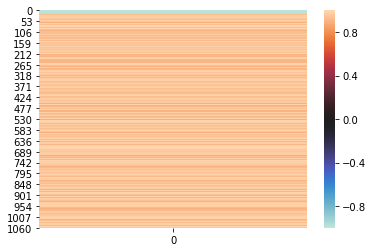

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 191
Hypothetical scores:


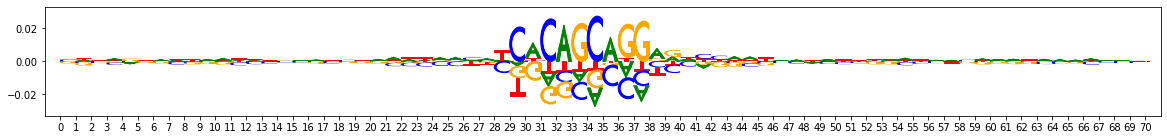

Actual importance scores:


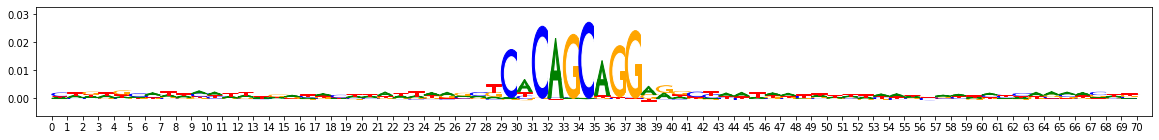

onehot, fwd and rev:


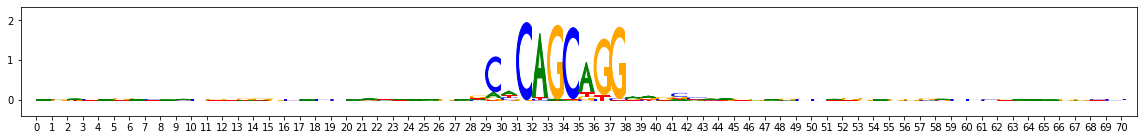

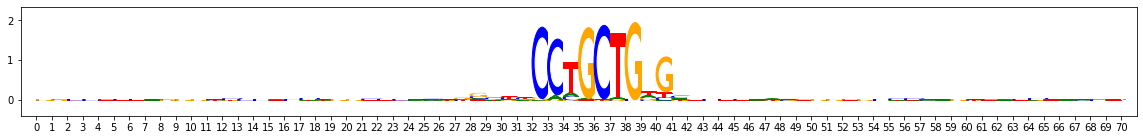

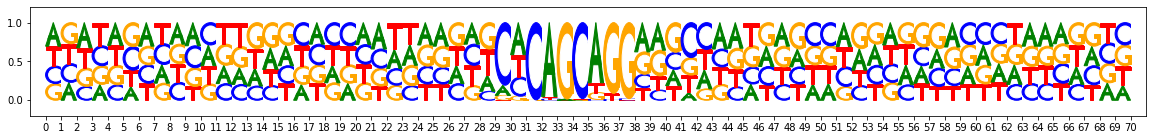

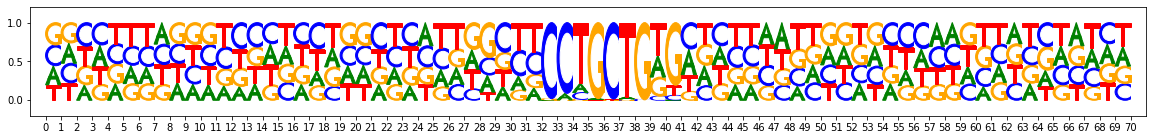

metacluster_0 pattern_1
total seqlets: 186
Hypothetical scores:


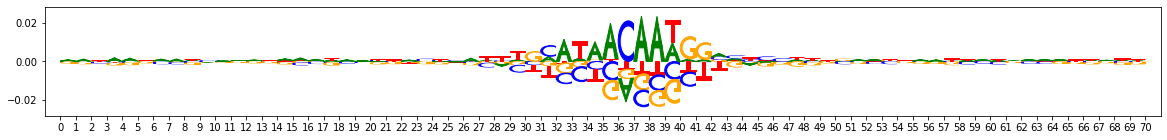

Actual importance scores:


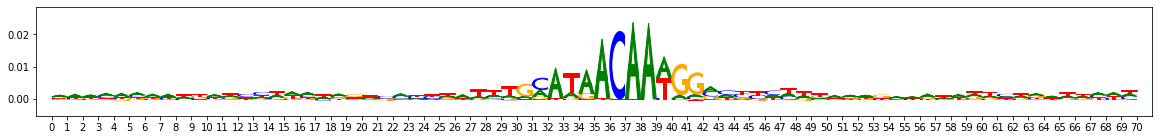

onehot, fwd and rev:


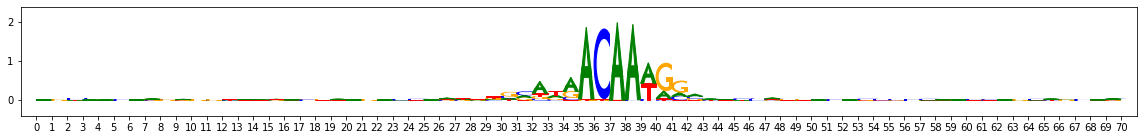

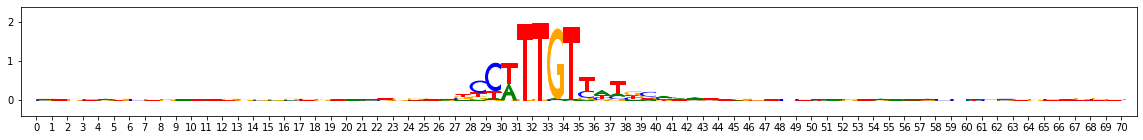

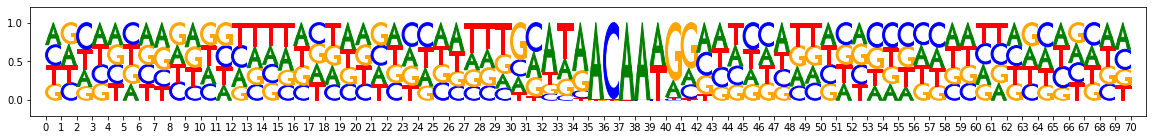

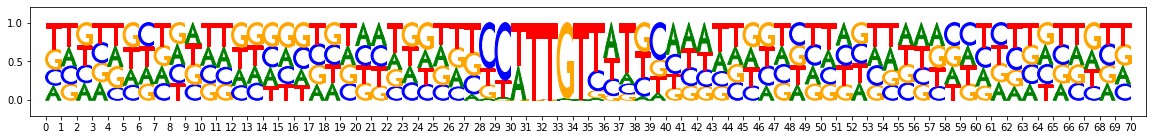

metacluster_0 pattern_2
total seqlets: 91
Hypothetical scores:


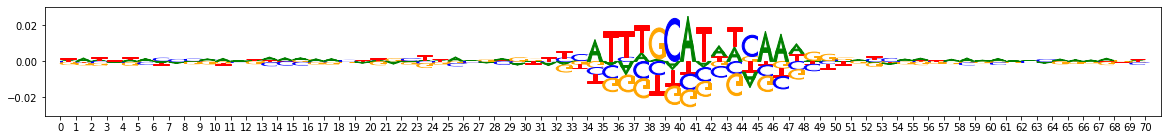

Actual importance scores:


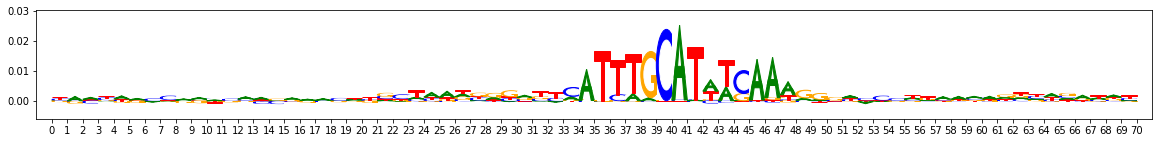

onehot, fwd and rev:


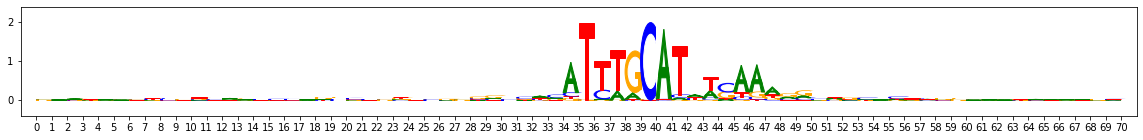

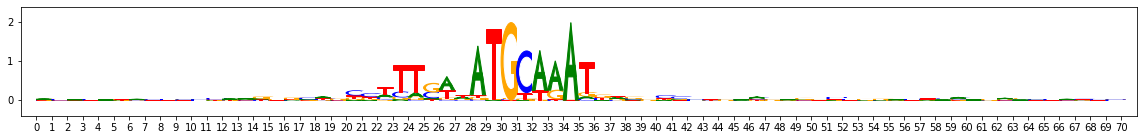

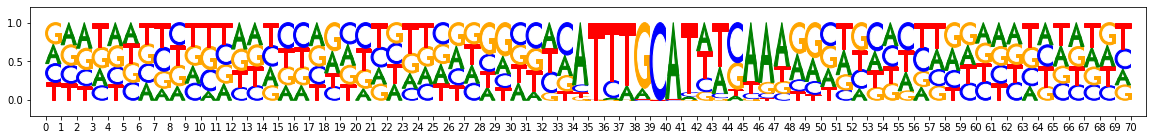

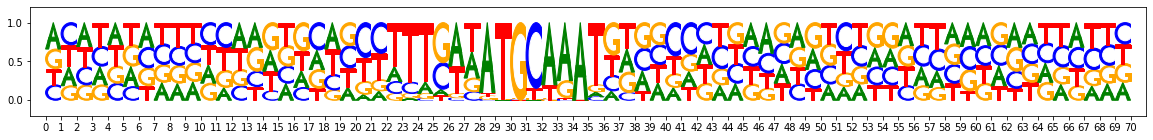

metacluster_0 pattern_3
total seqlets: 56
Hypothetical scores:


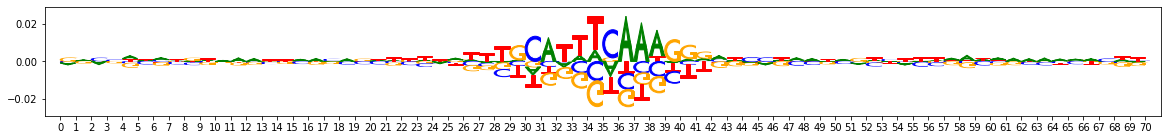

Actual importance scores:


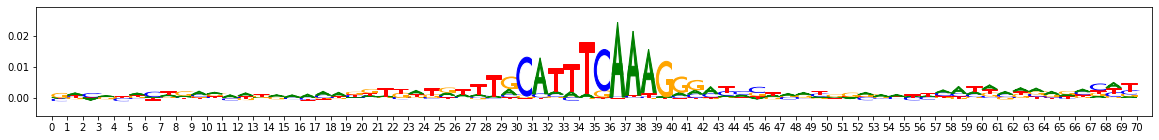

onehot, fwd and rev:


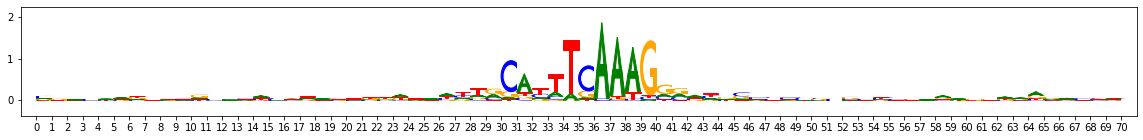

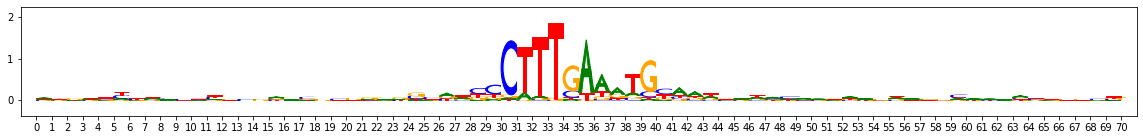

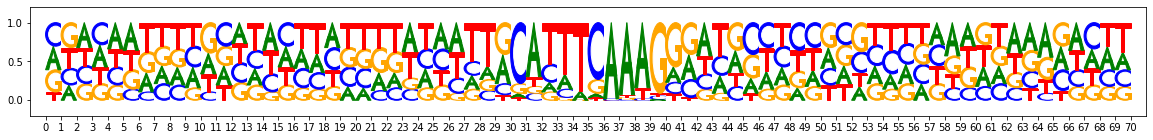

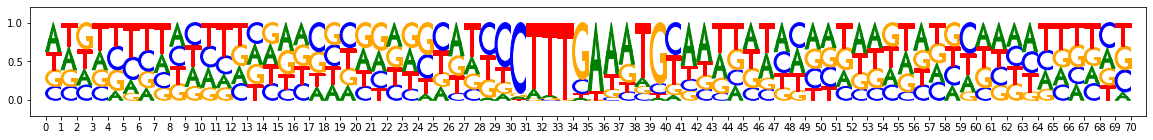

metacluster_0 pattern_4
total seqlets: 48
Hypothetical scores:


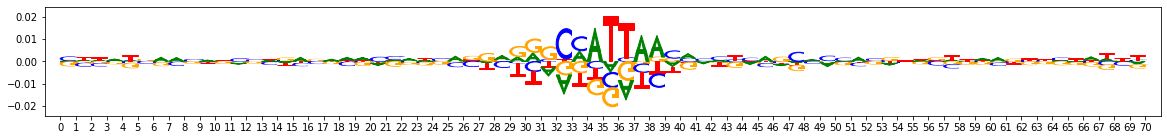

Actual importance scores:


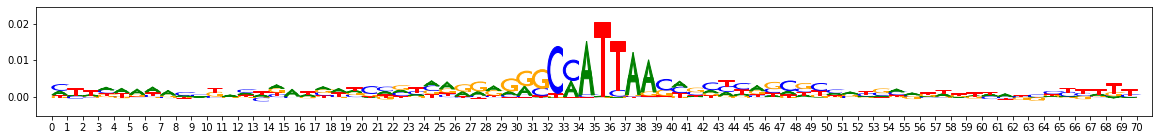

onehot, fwd and rev:


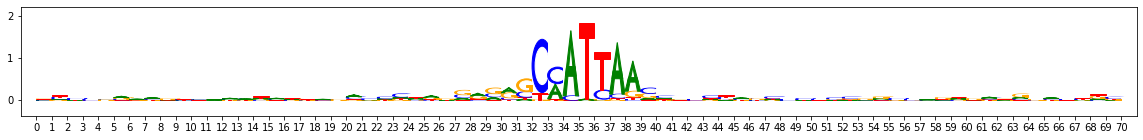

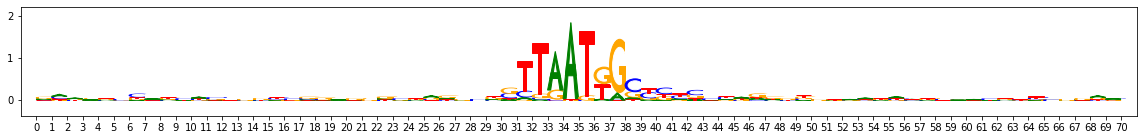

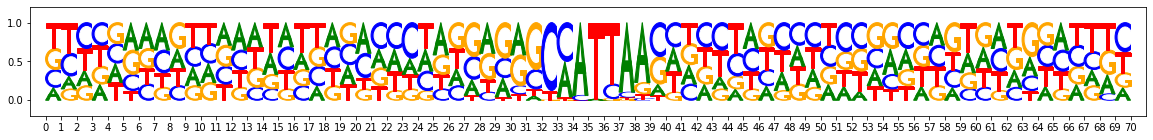

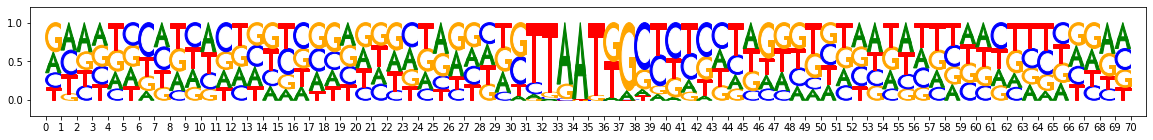

metacluster_0 pattern_5
total seqlets: 36
Hypothetical scores:


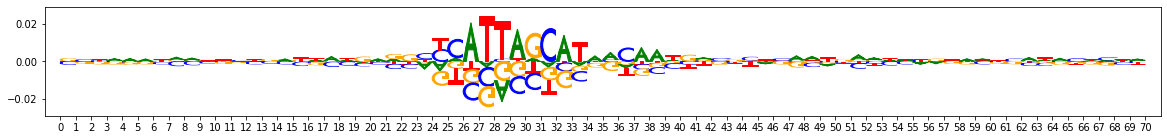

Actual importance scores:


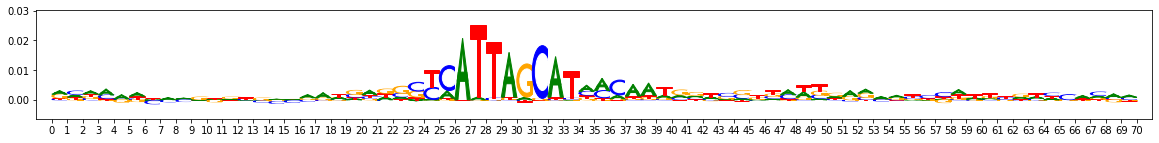

onehot, fwd and rev:


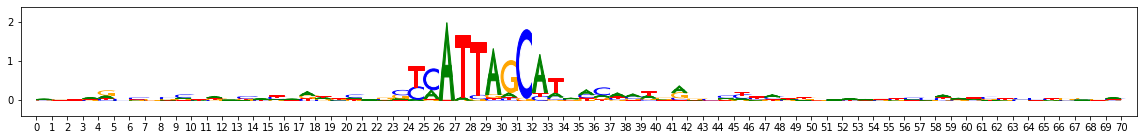

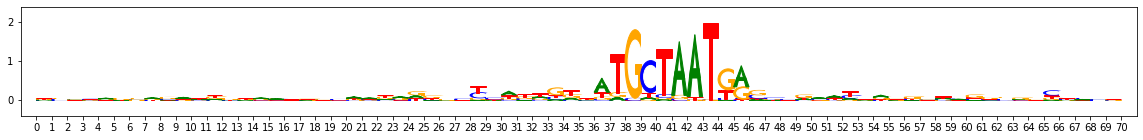

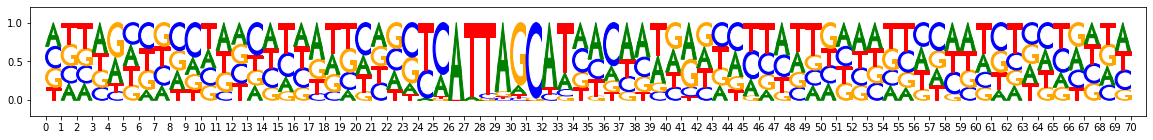

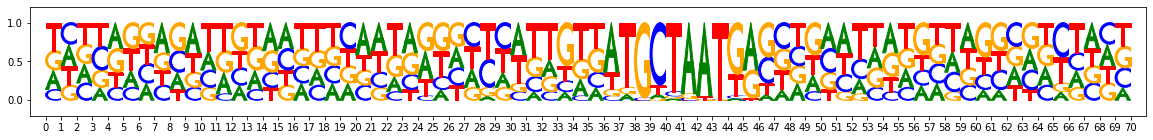

In [8]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()

### (extra) Visualize the result of using MEME's motifs to initialize the seqlets
This visualizes the intermediate stage where the MEME-derived motifs are used to create an initial set of seqlet clusters. Can be used to get insight into how the MEME-based initialization influenced the TF-MoDISco results

Inspecting meme-based initialization for seqlets in round 1
round 1 MEME-DISco motif number 0
num seqlets mapped to this motif: 197


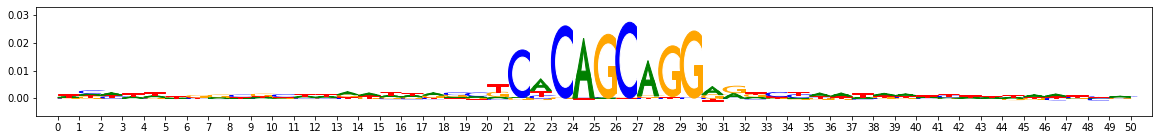

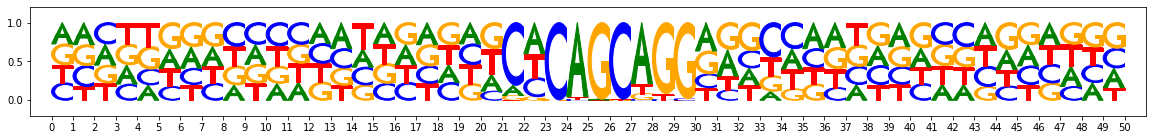

round 1 MEME-DISco motif number 1
num seqlets mapped to this motif: 189


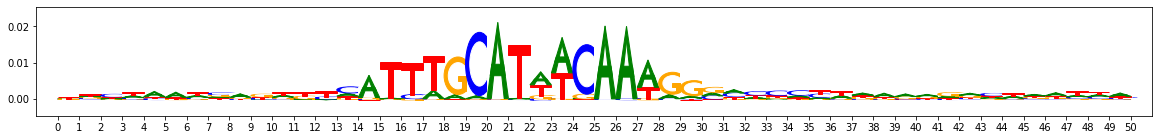

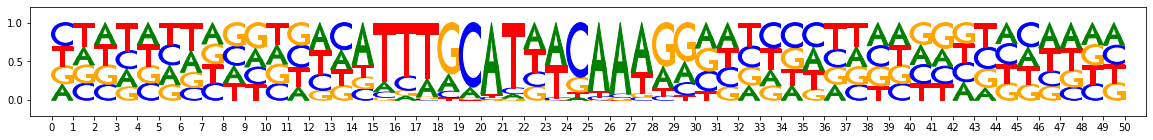

round 1 MEME-DISco motif number 2
num seqlets mapped to this motif: 124


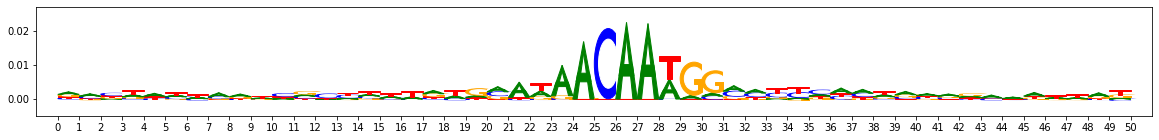

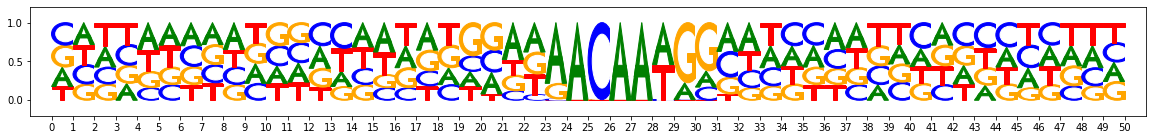

round 1 MEME-DISco motif number 3
num seqlets mapped to this motif: 56


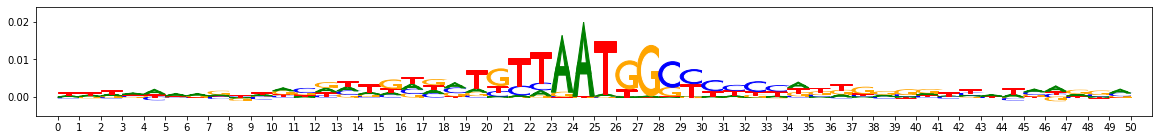

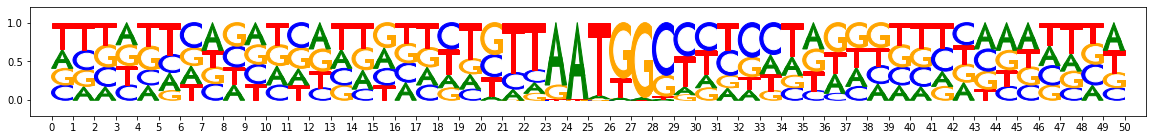

round 1 MEME-DISco motif number 4
num seqlets mapped to this motif: 13


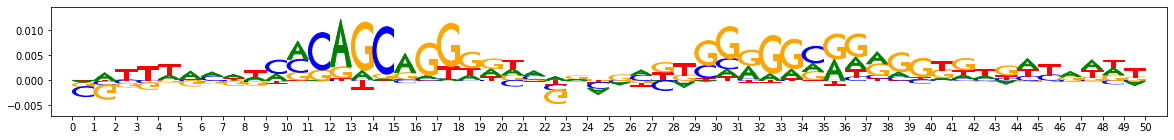

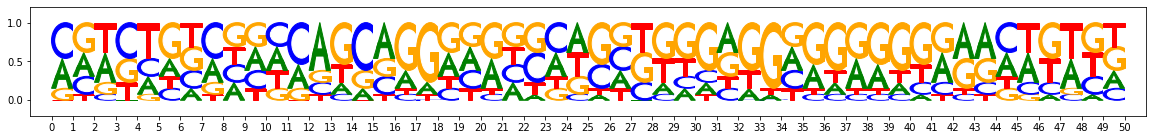

In [9]:
from modisco.visualization import viz_sequence
for round_idx in [1]:
    print("Inspecting meme-based initialization for seqlets in round",round_idx)
    meme_discovered_motifs = (tfmodisco_results
        .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
        .each_round_initcluster_motifs[round_idx])
    for idx,motif in enumerate(meme_discovered_motifs):
        print("round",round_idx,"MEME-DISco motif number",idx)
        print("num seqlets mapped to this motif:",len(motif.seqlets))
        viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(motif["sequence"].fwd)